In [12]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

# pd.set_option('display.max_colwidth', 200)
%matplotlib inline



In [17]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv", on_bad_lines='skip')
candidate_sentences.shape

(28, 2)

In [23]:
candidate_sentences.sample(4)

confused and frustrated  \
17  kota eberhardt portrays telepath selene gallio   
1         christian is then paralyzed by an elder.   
8                  we just tried to make the film.   
2                       the temple is set on fire.   

    connie decides to leave on her own.  
17                                  NaN  
1                                   NaN  
8                                   NaN  
2                                   NaN

In [24]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [25]:
#here extract single word entity from sentence. Nouns in sentences are going to be the entities
#in knownledge graph nodes are entities and edges are relation
#extract them in a unsupervised manner in file 
#go through a sentence and extract the subject and the object as and when they are encountered.
#function below to extract the subject and the object (entities) from a sentence.Comtemplates previous terms of compound words and modifiers.
#ex compound word:'Baseball Stadium'. ex modifier: 'big house'

def get_entities(sent):
  ## chunk 1
  ent1 = "" #first node. Subject is stored here
  ent2 = "" #second node. Object is sored here

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it 
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [29]:
#jose saramago is subject
#40 books is object
get_entities("jose saramago wrote 40 books")

['jose saramago', '40  books']

In [34]:
entity_pairs = [] #this array is going to store all pairs subject object that is in dataset

for i in tqdm(candidate_sentences):
  entity_pairs.append(get_entities(i))

  7%|▋         | 2/28 [00:00<00:00, 188.13it/s]


In [38]:
entity_pairs[1:2]

[['connie', 'own']]

In [45]:
#this function extract edges to connect the nodes. Capture predicates from sentence
#the predicate is the main verb in a sentence
#using spacy rule-based matching

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'},  #ROOT word is the main verb in a sentence
            {'DEP':'prep','OP':"?"}, #checks if root is followed by a preposition
            {'DEP':'agent','OP':"?"},  #checks if root is followed by an agent
            {'POS':'ADJ','OP':"?"}]  #if yes, ROOT receives main verb

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)



In [47]:
#'wrote' is the predicate
get_relation("jose saramago wrote 40 books")

'wrote'

In [49]:
relations = [get_relation(i) for i in tqdm(candidate_sentences)]

  7%|▋         | 2/28 [00:00<00:00, 183.61it/s]


In [50]:
pd.Series(relations).value_counts()[:50]

confused    1
decides     1
dtype: int64

In [51]:
print('KNOWLEDGDE GRAPH BUILD')

KNOWLEDGDE GRAPH BUILD


In [52]:
#create dataframe of entities and predicates

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [53]:

#uses networkx library to create network from dataframe
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

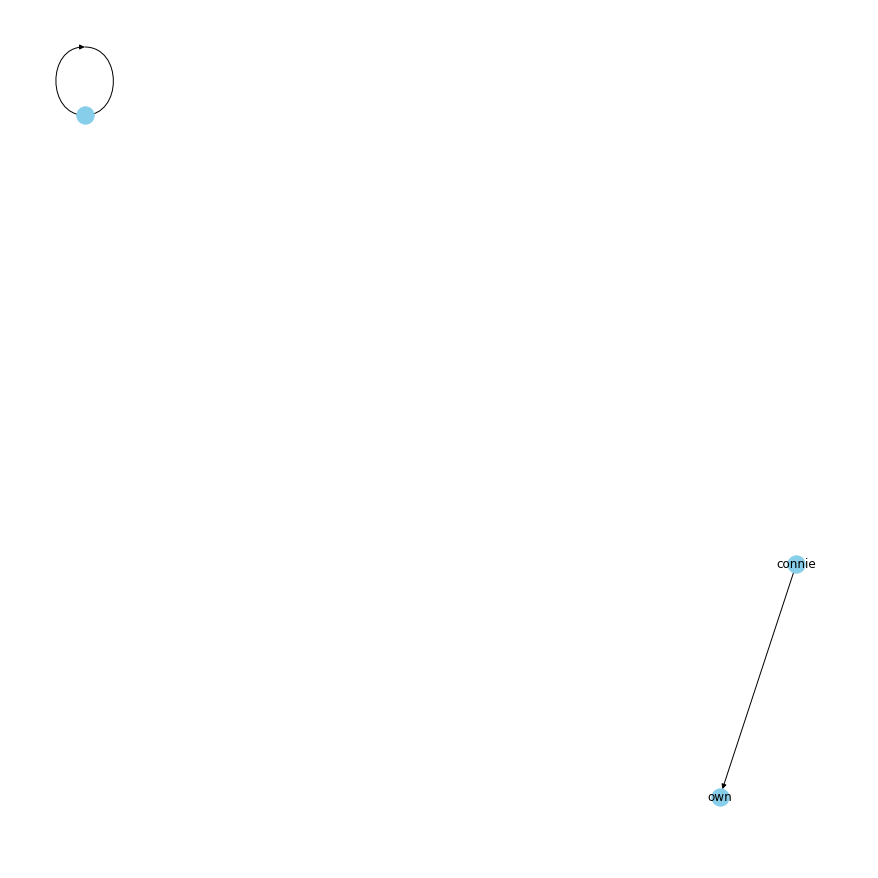

In [56]:
#plot network

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


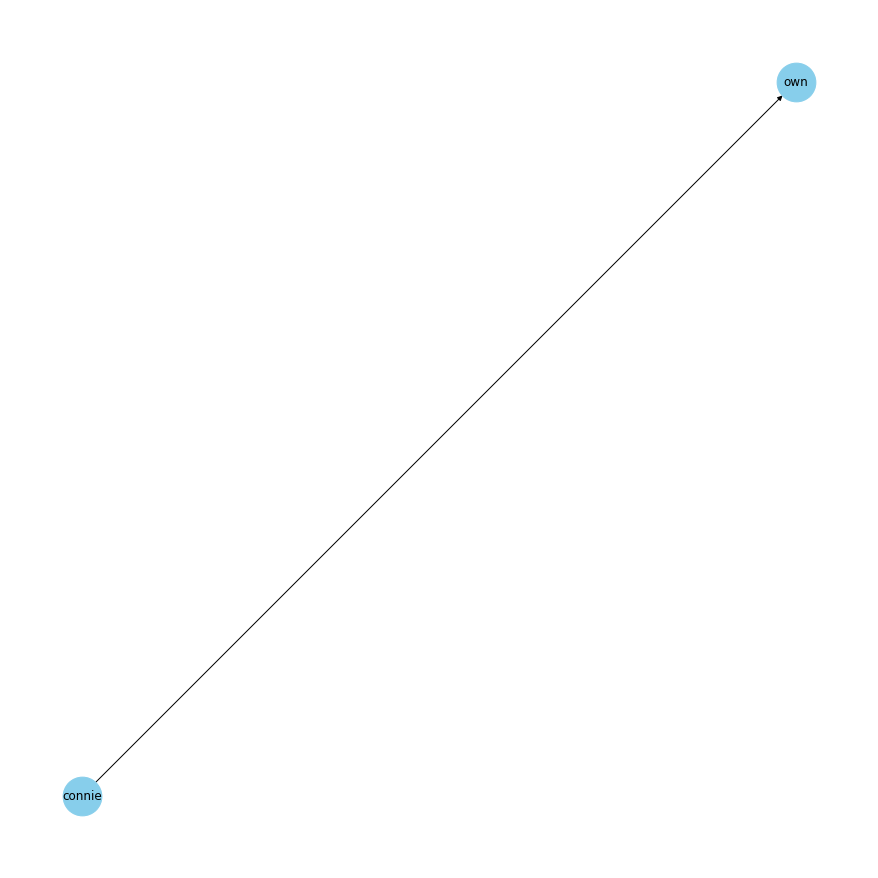

In [59]:
#specified predicate
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="decides"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

